In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../src'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/home/enis/projects/nna/src


In [31]:
import numpy as np 
from numpy import linspace
import pandas as pd


from datetime import datetime,timedelta
from pathlib import Path

# from scipy import stats
# import time
# import copy

# import csv 
# from os import listdir
# import pickle

# from tabulate import tabulate


# import math

# import itertools

# from pytz import timezone




In [6]:
from pre_process_func import read_queue
from fileUtils import read_file_properties
from labeling_utils import load_labels


In [7]:
flder="/home/enis/projects/nna/data/"

files_list_path=flder+"mp3files.txt"
fileswlen_path = flder+"mp3files_wlen.txt"

# files_list_path=flder+"flacfiles.txt"
# fileswlen_path = flder+"flacfiles_wlen.txt"

coordinates_fpath= flder + "NNA_recording_devices.csv"

In [9]:
file_properties_df=pd.read_pickle("../../data/stinchcomb_dataV1.pkl")


In [10]:
id2name={}
id2name['09-USGS']="USGS"
id2name['19-Itkillik2']="Itkilik 2"
id2name['01-Itkillik']="Itkilik 1"
id2name['02-Colville2']="Colville 2"
id2name['03-OceanPt']="Ocean Pt"
id2name['04-Colville4']="Colville 4"
id2name['05-Colville5']="Colville 5"




In [13]:
tag_set=["Songbird","Water Bird","Insect","Running Water","Rain","Cable","Wind","Aircraft"]


In [17]:
# possible places to pick
# sorted(pd.unique(file_properties_df.site_id.values))
selected_areas=['05-Colville5',
'19-Itkillik2',
'04-Colville4',
# '20-Umiat', # old data
'03-OceanPt',
'02-Colville2',
'01-Itkillik',
'09-USGS']


# selected_areas=["15","21","22","27","31","35","37","48",]

#important to keep them in order
file_properties_df.sort_values(by=['timestamp'],inplace=True)

# delete older than 2016
fromtime=datetime(2016, 1, 1, 0)
file_properties_df=file_properties_df[file_properties_df.timestamp>=fromtime]


In [18]:
model_tag_names=["Neural Net_Songbird",
"Neural Net_Water Bird",
"Neural Net_Insect",
"Neural Net_Running Water",
"Neural Net_Rain",
"Neural Net_Cable",
"Neural Net_Wind",
"Neural Net_Aircraft",]

# inference_file="/home/enis/projects/nna/notebooks/Visualizations/Neural Net_Insect_tags_on_real_Dec:6.npy"
inference_file="/home/enis/projects/nna/notebooks/Visualizations/8tags_on_8sites_pathV2.npy"
gathered_results_perTag=np.load(inference_file,allow_pickle=True)[()]



In [19]:
# inference_file="/home/enis/projects/nna/notebooks/Visualizations/Neural Net_Insect_tags_on_real_Dec:6.npy"
inference_file="/home/enis/projects/nna/notebooks/Visualizations/8tags_on_8sites.npy"
gathered_results_perTag=np.load(inference_file,allow_pickle=True)[()]



In [23]:
# PARAMS
# FREQS to reduce results 
# freq="2H"
# minutely freq
freq="T"

selected_tag_name=model_tag_names[0]

In [42]:
area_filtered2=file_properties_df[file_properties_df.site_id=="asd"]
area_filtered2.size

0

In [44]:
times=[]
# FIND earliest and latest time for time scale
# lists in selected_areas_dict is ordered by time
for i,area in enumerate(selected_areas):
    # get timestamp values from file_properties
    area_filtered=file_properties_df[file_properties_df.site_id==area]
    if area_filtered.size>0:
        start=area_filtered.iloc[0]["timestamp"]
        end=area_filtered.iloc[-1]["timestamp"]

        times.extend([start,end])
    else:
        print("{}, do not have any files".format(area))

times.sort()
all_start=times[0].replace(hour=0,minute=0,second=0)
all_end=times[-1].replace(hour=23,minute=59,second=59)


def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

#create date axis indexes depending on start,end along with frequency
if "H" in freq:
    number_hours=3600
    count=int(freq[:-1])
    extra=math.ceil(3/count)
    globalindex = pd.date_range(all_start, periods=((all_end-all_start).total_seconds()//(number_hours*count)+48), freq=freq)
elif "D" in freq:
    globalindex = pd.date_range(all_start, periods=(all_end-all_start).days+3, freq=freq)
elif "T" in freq:
    globalindex = pd.date_range(all_start,all_end, freq=freq)

globalcolumns=model_tag_names#selected_areas+weather_cols



In [27]:
print(" Duration of selected data period:",(all_end-all_start).days,"days")
print(" Starts: {} \n Ends:   {}".format(all_end,all_start))

 Duration of selected data period: 86 days
 Starts: 2016-08-27 23:59:59 
 Ends:   2016-06-02 00:00:00


In [32]:
df_dict={key: None for (key) in selected_areas}
no_result_paths=[]
# gathered_results=gathered_results_perTag[model_tag_name+tag_name]
# all    pd.unique(file_properties_df.site_id )

for i,area in enumerate(selected_areas):
    df_sums = pd.DataFrame(index=globalindex, columns=globalcolumns).fillna(0)
    df_count = pd.DataFrame(index=globalindex, columns=globalcolumns).fillna(0)
    
    for tag_name in model_tag_names:
#         for afile in selected_areas_dict[area]:
        area_filtered=file_properties_df[file_properties_df.site_id==area]
        for afile in area_filtered.index:
    #         data=gathered_results[afile][0]
            afile=Path(afile)
            data=gathered_results_perTag[tag_name].get(afile,[])[:]
            if type(data)==list:
#                 print(afile)
                no_result_paths.append(afile)
                pass

            start=file_properties_df.loc[afile]["timestamp"]

            index = pd.date_range(start,start+timedelta(seconds=(10*(len(data)-1))), freq="10S")

            df_afile=pd.DataFrame(data,index=index,columns=[tag_name])

            df_afile_grouped = df_afile.groupby([pd.Grouper(freq=freq)])
            counts=df_afile_grouped.count()
            sums=df_afile_grouped.sum()
            df_count.update(counts)
            df_sums.update(sums)
    
    df_dict[area]=(df_count.copy(),df_sums.copy())


print("{} number of files do not have results".format(len(no_result_paths)))



1832 number of files do not have results


In [153]:
df_sums_max=df_sums.idxmax(axis=1)

mapping = dict(zip(model_tag_names,range(0,len(model_tag_names))))

df_sums_max=df_sums_max.replace(mapping)

In [162]:
df_sums_max.groupby([pd.Grouper(freq="24H")])

In [176]:
df_sums_max_np=df_sums_max.values.reshape(-1,1440)

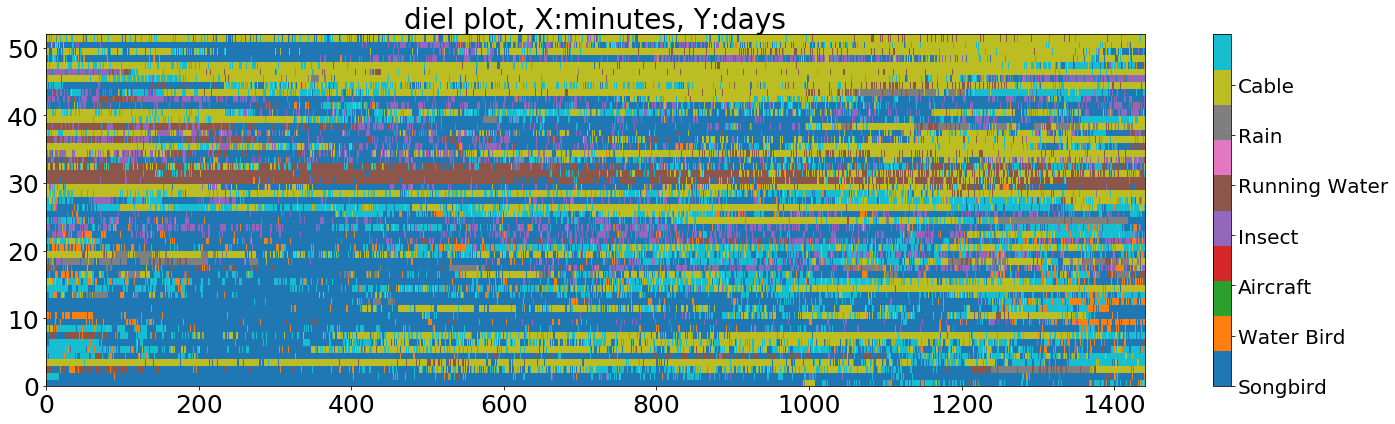

In [213]:
# Z = np.random.randint(0,7,(10,1440))
Z = df_sums_max_np[:]
# fig, (ax0, ax1) = plt.subplots(2, 1)
fig, (ax0) = plt.subplots(figsize=(20,6),nrows=1)

c = ax0.pcolormesh(Z,cmap=plt.get_cmap("tab10"))
ax0.set_title('diel plot, X:minutes, Y:days',fontsize=28)

# c = ax1.pcolor(Z, edgecolors='k', linewidths=4)
# ax1.set_title('thick edges')
cbar=fig.colorbar(c);
cbar.set_ticks([i for i in range(7)])
cbar.set_ticklabels([model_tag_names[i][11:] for i in range(7)])

cbar.ax.tick_params(labelsize=20)
ax0.tick_params(labelsize=22,which="minor")
ax0.tick_params(labelsize=25,which="major")

fig.tight_layout()
# plt.show()
fig.savefig("diel_plot_v1"+'.png')

